# Matrix completion and recommender systems


[MovieLens](movielens.umn.edu) data sets were collected by the [GroupLens Research Project](http://www.grouplens.org/) at the University of Minnesota.

This data set consists of:

- 100000 ratings (1-5) from 943 users on 1682 movies.
- Each user has rated at least 20 movies.

The `movielens.csv` file contains the full dataset. Users and items are numbered consecutively from 1. The data is randomly ordered. This is a tab separated list of

```
user id | item id | rating | timestamp
```


In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from scipy.sparse import csr_matrix
from scipy.stats import pearsonr


Read the dataset from the `movielens.csv` file.


In [2]:
dataset = pd.read_csv("movielens.csv", sep="\t", header=None)
dataset.describe()

,0,1,2,3
count,100000.00000,100000.000000,100000.000000,1.000000e+05
mean,462.48475,425.530130,3.529860,8.835289e+08
std,266.61442,330.798356,1.125674,5.343856e+06
min,1.00000,1.000000,1.000000,8.747247e+08
25%,254.00000,175.000000,3.000000,8.794487e+08
50%,447.00000,322.000000,4.000000,8.828269e+08
75%,682.00000,631.000000,4.000000,8.882600e+08
max,943.00000,1682.000000,5.000000,8.932866e+08


How many movies? How many people? How many ratings?


In [8]:
n_users = np.unique(dataset[0]).shape[0]
n_movies = np.unique(dataset[1]).shape[0]
n_ratings = dataset.shape[0]

print(f"number of users: {n_users}")
print(f"number of movies: {n_movies}")
print(f"number of ratings: {n_ratings}")

number of users: 943
number of movies: 1682
number of ratings: 100000


Shuffle the data (see the function [`np.random.shuffle`](https://numpy.org/doc/stable/reference/random/generated/numpy.random.shuffle.html)).


In [9]:
idxs = np.arange(n_ratings)

np.random.seed(42)
np.random.shuffle(idxs)

rows = dataset[0].to_numpy() - 1
rows = rows[idxs]

cols = dataset[1].to_numpy() - 1
cols = cols[idxs]

vals = dataset[2].to_numpy()
vals = vals[idxs]

Split the dataset into a subset of 80000 training ratings and 20000 testing ratings.


In [10]:
train_size = int(0.8 * n_ratings)

train_rows = rows[:train_size]
train_cols = cols[:train_size]
train_vals = vals[:train_size]

test_rows = rows[train_size:]
test_cols = cols[train_size:]
test_vals = vals[train_size:]

Let us denote by $\Omega$ the set of pairs $(i,j)$ such that rating of the $i$-th user on the $j$-th movie is available in the training set (similarly, $\Omega_{\text{test}}$ is the set of testing pairs).
Let us denote by $r_{ij}$ the corresponding rating.

Create a full matrix $X \in \mathbb{R}^{n \times p}$, such that:

$$
X_{i,j} =
\begin{cases}
r_{ij} & \text{if } (i,j) \in \Omega\\
0& \text{otherwise}
\end{cases}
$$


In [11]:
X_sparse = csr_matrix((train_vals, (train_rows, train_cols)), shape=(n_users, n_movies))
X = X_sparse.toarray() 

## Trivial recommender system

Create a trivial recommender system, based on the average rating of each user:

$$
r^{\text{pred}}_{ij} = \frac{1}{N_i} \sum_{j : (i,j) \in \Omega} r_{ij}
$$

where $N_i = card(j : (i,j) \in \Omega)$.

Then compute the RMSE (root mean square error):

$$
\text{RMSE} = \sqrt{\frac{1}{card(\Omega_{\text{test}})} \sum_{(i,j) \in \Omega_{\text{test}}} (r_{ij} - r^{\text{pred}}_{ij})^2}
$$

and the Pearson correlation coefficient $\rho$ (use the function [scipy.stats.pearsonr](https://docs.scipy.org/doc/scipy/reference/generated/scipy.stats.pearsonr.html)):

$$
\rho =
\frac
{
    \displaystyle\sum_{(i,j) \in \Omega_{\text{test}}}
       (r_{ij} - \overline{r})
       (r^{\text{pred}}_{ij} - \overline{r}^{\text{pred}})
}
{\sqrt{
    \displaystyle\sum_{(i,j) \in \Omega_{\text{test}}}
       (r_{ij} - \overline{r})^2
       }
\sqrt{
    \displaystyle\sum_{(i,j) \in \Omega_{\text{test}}}
       (r^{\text{pred}}_{ij} - \overline{r}^{\text{pred}})^2
       }}
$$

where

$$
\begin{split}
\overline{r} &= \frac{1}{card(\Omega_{\text{test}})} \sum_{(i,j) \in \Omega_{\text{test}}}
       r_{ij}
\\
\overline{r}^{\text{pred}} &= \frac{1}{card(\Omega_{\text{test}})} \sum_{(i,j) \in \Omega_{\text{test}}}
       r^{\text{pred}}_{ij}
\end{split}
$$


In [12]:
avg_rating = np.array([np.mean(train_vals[train_rows == i]) for i in range(n_users)])
vals_trivial = avg_rating[test_rows]

errors_trivial = np.abs(vals_trivial - test_vals)

RMSE_trivial = np.sqrt(np.mean(errors_trivial**2))
rho_trivial = pearsonr(vals_trivial, test_vals)[0]

print(f"RMSE (trivial): {RMSE_trivial:.4f}")
print(f"Pearson correlation (trivial): {rho_trivial:.4f}")

RMSE (trivial): 1.0433
Pearson correlation (trivial): 0.3851


# Singular value truncation (SVT) based recommender system


Implement the SVT algorithm to predict the ratings of the testing set. Set a maximum number of iterations equal to 100. Print the RMSE and $\rho$ at each iteration. Finally, plot the trend of both metrics.

Try to calibrate the threshold to get better results.


In [22]:
max_iter = 100
threshold = 100.0

increment_tol = 1e-6

RMSE = []
rho = []

A = X.copy()

for it in range(max_iter):
    A_old = A.copy()

    U, S, VT = np.linalg.svd(A, full_matrices=False)
    S[S < threshold] = 0

    A = U @ np.diag(S) @ VT

    A[train_rows, train_cols] = train_vals
    increment = np.linalg.norm(A - A_old)

    vals_pred = A[test_rows, test_cols]
    errors = np.abs(vals_pred - test_vals)

    RMSE.append(np.sqrt(np.mean(errors**2)))
    rho.append(pearsonr(vals_pred, test_vals)[0])

    print(f"----- Iteratiorn {it+1} -----")
    print(f"MSE: {RMSE[-1]:.4f}")
    print(f"rho: {rho[-1]:.4f}")

    if increment < increment_tol:
        print("Converged!")
        break

----- Iteratiorn 1 -----
MSE: 2.6160
rho: 0.3215
----- Iteratiorn 2 -----
MSE: 2.1710
rho: 0.3477
----- Iteratiorn 3 -----
MSE: 1.9248
rho: 0.3674
----- Iteratiorn 4 -----
MSE: 1.7656
rho: 0.3829
----- Iteratiorn 5 -----
MSE: 1.6531
rho: 0.3955
----- Iteratiorn 6 -----
MSE: 1.5689
rho: 0.4061
----- Iteratiorn 7 -----
MSE: 1.5035
rho: 0.4151
----- Iteratiorn 8 -----
MSE: 1.4510
rho: 0.4230
----- Iteratiorn 9 -----
MSE: 1.4080
rho: 0.4299
----- Iteratiorn 10 -----
MSE: 1.3721
rho: 0.4361
----- Iteratiorn 11 -----
MSE: 1.3416
rho: 0.4416
----- Iteratiorn 12 -----
MSE: 1.3155
rho: 0.4466
----- Iteratiorn 13 -----
MSE: 1.2927
rho: 0.4512
----- Iteratiorn 14 -----
MSE: 1.2728
rho: 0.4554
----- Iteratiorn 15 -----
MSE: 1.2553
rho: 0.4593
----- Iteratiorn 16 -----
MSE: 1.2396
rho: 0.4629
----- Iteratiorn 17 -----
MSE: 1.2256
rho: 0.4662
----- Iteratiorn 18 -----
MSE: 1.2130
rho: 0.4692
----- Iteratiorn 19 -----
MSE: 1.2015
rho: 0.4721
----- Iteratiorn 20 -----
MSE: 1.1911
rho: 0.4748
----- Ite

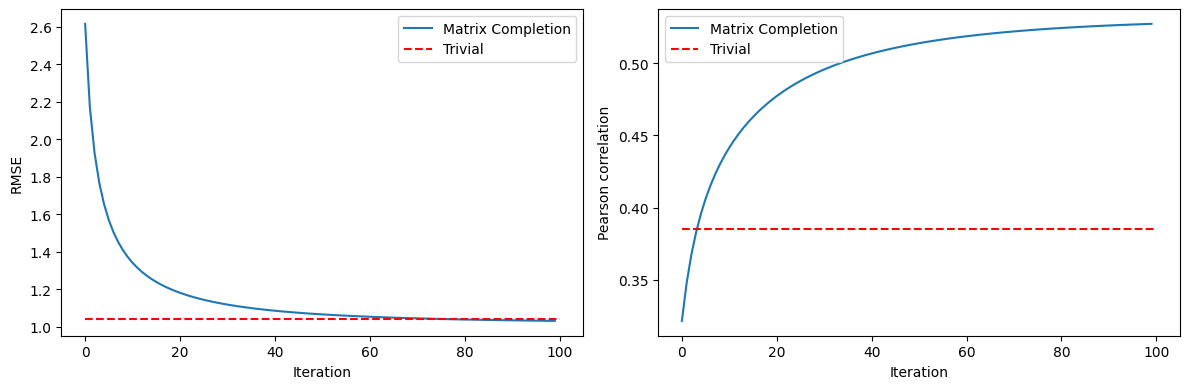

In [23]:
fig, ax = plt.subplots(1, 2, figsize=(12, 4))

ax[0].plot(RMSE, label="Matrix Completion")
ax[0].hlines(RMSE_trivial, 0, len(RMSE), colors="r", linestyles="dashed", label="Trivial")
ax[0].set_xlabel("Iteration")
ax[0].set_ylabel("RMSE")
ax[0].legend()

ax[1].plot(rho, label="Matrix Completion")
ax[1].hlines(rho_trivial, 0, len(rho), colors="r", linestyles="dashed", label="Trivial")
ax[1].set_xlabel("Iteration")
ax[1].set_ylabel("Pearson correlation")
ax[1].legend()

plt.tight_layout()